# Setup

In [1]:
import gc
gc.enable()

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(category=FutureWarning, action='ignore')
warnings.filterwarnings(category=UserWarning, action='ignore')

import time
import joblib
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold
)
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    roc_auc_score,
    confusion_matrix
)
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier,
    HistGradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier
)
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

SEED = 2024

# Data preparation

In [2]:
data = pd.read_csv('../Dataset/online_course_engagement_data.csv')

In [3]:
TARGET = 'CourseCompletion'
features = [f for f in data.columns if f not in ('UserID', TARGET)]
cat_features = ['DeviceType', 'CourseCategory']
num_features = [f for f in features if f not in cat_features]

### Preprocessing

In [4]:
def preprocess_dataset(df):
    # remove duplicates
    df = df.drop_duplicates(ignore_index=True)
    
    # one-hot encoding nominal variable
    df = pd.get_dummies(df, columns=['CourseCategory'], dtype='int8')
    
    df['DeviceType'] = df['DeviceType'].astype('int8')
    
    # binarize numerical features
    df['time_spent_above_threshold'] = (df['TimeSpentOnCourse'] > 20).astype('int8')
    df['num_videos_above_threshold'] = (df['NumberOfVideosWatched'] > 5).astype('int8')
    df['num_quizzes_above_threshold'] = (df['NumberOfQuizzesTaken'] > 3).astype('int8')
    df['quiz_scores_above_threshold'] = (df['QuizScores'] > 68).astype('int8')
    df['completion_above_threshold'] = (df['CompletionRate'] > 60).astype('int8')
    
    return df

In [5]:
data = preprocess_dataset(data.copy())

### Feature sets

Generated in: [Online Course Engagement - Logistic Regression](https://www.kaggle.com/code/sid4ds/online-course-engagement-logistic-regression)

In [6]:
original_features = [
    'TimeSpentOnCourse', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken', 
    'QuizScores', 'CompletionRate', 'DeviceType', 'CourseCategory_Arts', 
    'CourseCategory_Business', 'CourseCategory_Health', 
    'CourseCategory_Programming', 'CourseCategory_Science'
]

extended_features = [
    'TimeSpentOnCourse', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken', 
    'QuizScores', 'CompletionRate', 'DeviceType', 'CourseCategory_Arts', 
    'CourseCategory_Business', 'CourseCategory_Health', 
    'CourseCategory_Programming', 'CourseCategory_Science', 
    'time_spent_above_threshold', 'num_videos_above_threshold', 
    'num_quizzes_above_threshold', 'quiz_scores_above_threshold', 
    'completion_above_threshold'
]

binary_features = [
    'DeviceType', 'CourseCategory_Arts', 'CourseCategory_Business', 
    'CourseCategory_Health', 'CourseCategory_Programming', 
    'CourseCategory_Science', 'time_spent_above_threshold', 
    'num_videos_above_threshold', 'num_quizzes_above_threshold', 
    'quiz_scores_above_threshold', 'completion_above_threshold'
]

minimal_features = [
    'time_spent_above_threshold', 'num_videos_above_threshold', 
    'num_quizzes_above_threshold', 'quiz_scores_above_threshold', 
    'completion_above_threshold'
]

In [7]:
feature_sets = {
    'Original': original_features,
    'Extended': extended_features,
    'Binary': binary_features,
    'Minimal': minimal_features
}

### Holdout set for model-testing
(exactly the same as used in previous modeling experiments)

In [8]:
train, test, _, _ = train_test_split(
    data, data[TARGET],
    stratify=data[TARGET],
    test_size=0.1,
    shuffle=True,
    random_state=SEED
)

# Modeling framework

In [9]:
def cross_validate(estimator, feature_set, num_folds=9):
    global train, TARGET
    
    scores_auc, scores_acc = [], []
    X, y = train[feature_set], train[TARGET]
    
    cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)
    for fold, (train_ids, val_ids) in enumerate(cv.split(X, y)):
        X_train, y_train = X.iloc[train_ids], y.iloc[train_ids]
        X_val, y_val = X.iloc[val_ids], y.iloc[val_ids]
        
        model = clone(estimator)
        model.fit(X_train, y_train)
        probs = model.predict_proba(X_val)[:, 1]
        scores_auc.append(roc_auc_score(y_val, probs))
        preds = model.predict(X_val)
        scores_acc.append(accuracy_score(y_val, preds))
        
    scores_df = pd.DataFrame(
        data={'Accuracy': scores_acc, 'ROC-AUC': scores_auc}, 
        index=[f'Fold #{i+1}' for i in range(9)]
    )
    display(scores_df.T)

In [10]:
def refit_full_and_evaluate(model, feature_set):
    global train, TARGET
    
    model.fit(train[feature_set], train[TARGET])
    probs = model.predict_proba(test[feature_set])[:, 1]
    preds = model.predict(test[feature_set])
    
    accuracy = accuracy_score(test[TARGET], preds)
    auc = roc_auc_score(test[TARGET], probs)
    print(f'|| Accuracy: {accuracy:.4f} || ROC-AUC: {auc:.4f} ||\n')
    
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.set_title('Normalized Confusion Matrix')
    sns.heatmap(
        data=confusion_matrix(test[TARGET], preds, normalize='true'),
        annot=True, fmt='.4f', linewidths=0.1, cmap=plt.cm.Blues
    )
    plt.xlabel('Prediction')
    plt.ylabel('True label')
    plt.show()
    
    return model

In [11]:
def save_model(model, config):
    save_path = f'saved_models/{config}.joblib'
    joblib.dump(model, save_path)

In [12]:
def run_experiment(estimator, model_name, save=True):
    global feature_sets
    
    for fname, fset in feature_sets.items():
        print('\n', '-'*25, fname, '-'*25)
        start_time = time.time()
        print('Cross-validation:')
        cross_validate(estimator, fset)
        print('Refit to full training data and evaluate:\n')
        model = refit_full_and_evaluate(estimator, fset)
        end_time = time.time()
        print(f'\n(Time taken: {end_time - start_time:.2f} secs)')
        
        if save:
            save_model(model, f'{model_name}_{fname}')

# Logistic Regression

In [13]:
logreg = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty=None, random_state=SEED)
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.7774,0.7970,0.7980,0.7894,0.7808,0.7820,0.8054,0.7943,0.8153
ROC-AUC,0.8569,0.8585,0.8686,0.8703,0.8580,0.8578,0.8858,0.8720,0.8921


Refit to full training data and evaluate:

|| Accuracy: 0.7835 || ROC-AUC: 0.8666 ||



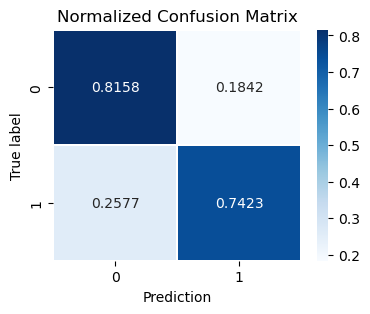


(Time taken: 1.65 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9584,0.9422,0.9494,0.9478,0.9531,0.9429,0.9536,0.9632,0.9678


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9630 ||



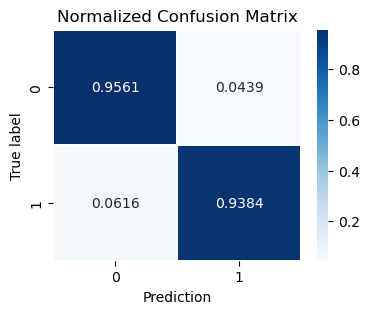


(Time taken: 1.10 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9473,0.9337,0.9394,0.9421,0.9513,0.9370,0.9429,0.9574,0.9584


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9553 ||



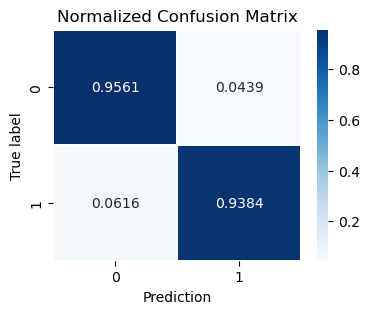


(Time taken: 1.50 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9465,0.9311,0.9403,0.9446,0.9501,0.9368,0.9472,0.9566,0.9579


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9545 ||



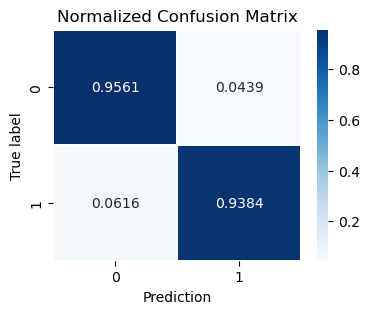


(Time taken: 0.85 secs)


In [14]:
run_experiment(logreg, 'logreg')

# Discriminant Analysis

## Linear

In [15]:
lda = make_pipeline(
    StandardScaler(), 
    LinearDiscriminantAnalysis(solver='svd', tol=1e-4)
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.7823,0.7934,0.7956,0.7857,0.7808,0.7833,0.8030,0.7968,0.8091
ROC-AUC,0.8569,0.8583,0.8686,0.8707,0.8581,0.8576,0.8858,0.8720,0.8921


Refit to full training data and evaluate:

|| Accuracy: 0.7798 || ROC-AUC: 0.8665 ||



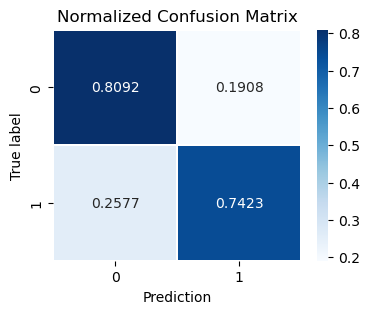


(Time taken: 1.60 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9557,0.9398,0.9466,0.9482,0.9546,0.9419,0.9527,0.9626,0.9644


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9597 ||



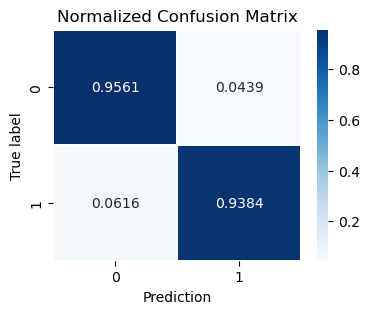


(Time taken: 0.95 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9461,0.9325,0.9377,0.9444,0.9531,0.9367,0.9447,0.9567,0.9545


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9514 ||



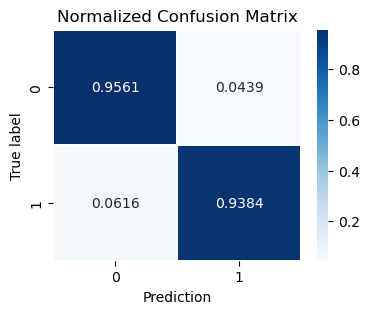


(Time taken: 1.46 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9464,0.9295,0.9385,0.9448,0.9536,0.9377,0.9498,0.9562,0.9538


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9517 ||



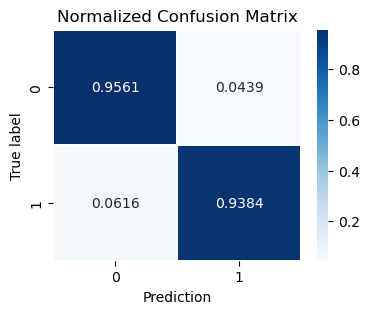


(Time taken: 1.97 secs)


In [16]:
run_experiment(lda, 'lda')

## Quadratic

In [17]:
qda = make_pipeline(
    StandardScaler(),
    QuadraticDiscriminantAnalysis(reg_param=0.25, tol=1e-4)
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.8069,0.8020,0.8165,0.8276,0.8140,0.8067,0.8276,0.8165,0.8424
ROC-AUC,0.8803,0.8768,0.8882,0.8933,0.8775,0.8814,0.9029,0.8925,0.9123


Refit to full training data and evaluate:

|| Accuracy: 0.8093 || ROC-AUC: 0.8883 ||



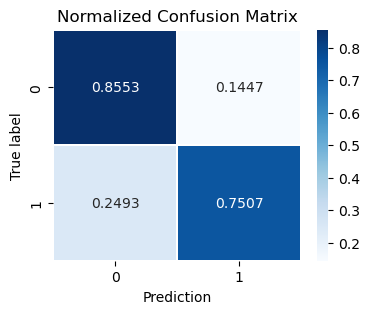


(Time taken: 1.48 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9274,0.9188,0.9335,0.9261,0.9126,0.9249,0.9249,0.9409,0.9483
ROC-AUC,0.9476,0.9320,0.9460,0.9428,0.9428,0.9442,0.9433,0.9578,0.9697


Refit to full training data and evaluate:

|| Accuracy: 0.9348 || ROC-AUC: 0.9593 ||



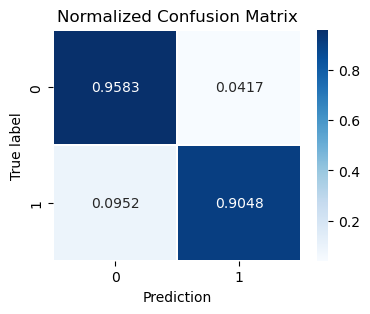


(Time taken: 2.52 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9250,0.9139,0.9273,0.9224,0.9150,0.9200,0.9236,0.9372,0.9421
ROC-AUC,0.9453,0.9346,0.9443,0.9344,0.9458,0.9428,0.9366,0.9564,0.9661


Refit to full training data and evaluate:

|| Accuracy: 0.9287 || ROC-AUC: 0.9568 ||



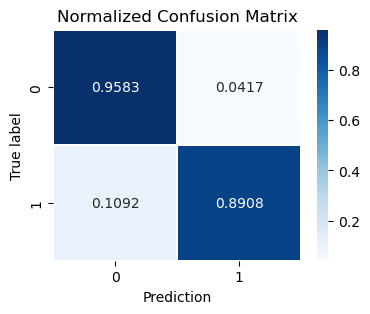


(Time taken: 1.97 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9250,0.9139,0.9273,0.9224,0.9150,0.9200,0.9236,0.9372,0.9421
ROC-AUC,0.9457,0.9315,0.9432,0.9337,0.9442,0.9438,0.9384,0.9561,0.9659


Refit to full training data and evaluate:

|| Accuracy: 0.9287 || ROC-AUC: 0.9561 ||



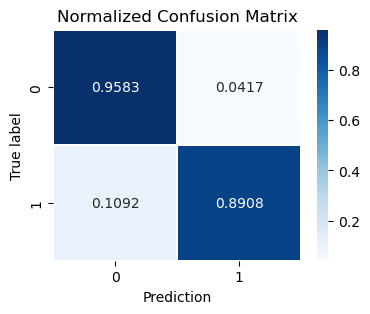


(Time taken: 1.36 secs)


In [18]:
run_experiment(qda, 'qda')

# Naive Bayes - GaussianNB

In [19]:
gaussnb = make_pipeline(StandardScaler(), GaussianNB())


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.8204,0.8057,0.8165,0.8337,0.8190,0.8177,0.8276,0.8350,0.8387
ROC-AUC,0.8912,0.8848,0.8921,0.9007,0.8886,0.8885,0.9097,0.9025,0.9188


Refit to full training data and evaluate:

|| Accuracy: 0.8278 || ROC-AUC: 0.8977 ||



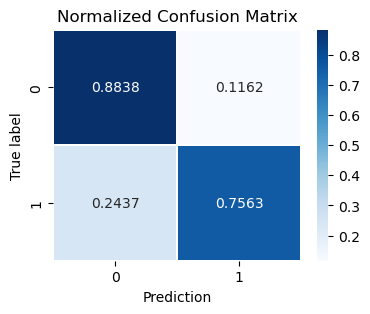


(Time taken: 2.20 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9176,0.9102,0.9163,0.9126,0.9002,0.9089,0.9163,0.9286,0.9372
ROC-AUC,0.9419,0.9252,0.9411,0.9361,0.9307,0.9382,0.9392,0.9490,0.9664


Refit to full training data and evaluate:

|| Accuracy: 0.9250 || ROC-AUC: 0.9532 ||



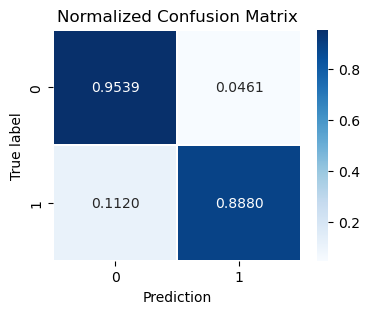


(Time taken: 1.90 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9250,0.9139,0.9224,0.9224,0.9150,0.9200,0.9126,0.9372,0.9421
ROC-AUC,0.9262,0.9168,0.9271,0.9169,0.9173,0.9208,0.9198,0.9326,0.9510


Refit to full training data and evaluate:

|| Accuracy: 0.9287 || ROC-AUC: 0.9388 ||



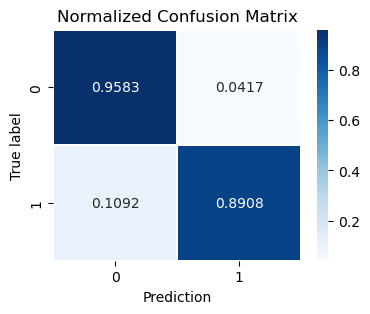


(Time taken: 2.00 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9250,0.9139,0.9273,0.9224,0.9150,0.9200,0.9236,0.9372,0.9421
ROC-AUC,0.9267,0.9154,0.9259,0.9154,0.9153,0.9208,0.9213,0.9332,0.9507


Refit to full training data and evaluate:

|| Accuracy: 0.9287 || ROC-AUC: 0.9371 ||



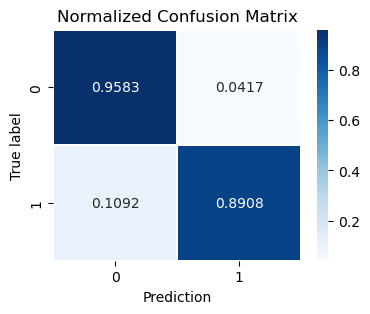


(Time taken: 1.78 secs)


In [20]:
run_experiment(gaussnb, 'gaussnb')

# K-Nearest Neighbors

In [21]:
knn = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(
        n_neighbors=10, 
        weights='distance', 
        n_jobs=-1
    )
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.8561,0.8475,0.8707,0.8695,0.8448,0.8436,0.8670,0.8571,0.8793
ROC-AUC,0.9188,0.9117,0.9176,0.9200,0.9193,0.9080,0.9246,0.9231,0.9392


Refit to full training data and evaluate:

|| Accuracy: 0.8438 || ROC-AUC: 0.9146 ||



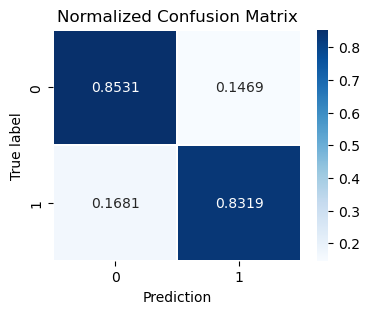


(Time taken: 3.53 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9422,0.9299,0.9446,0.9409,0.9433,0.9372,0.9360,0.9557,0.9557
ROC-AUC,0.9441,0.9380,0.9500,0.9467,0.9476,0.9339,0.9536,0.9605,0.9573


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9462 ||



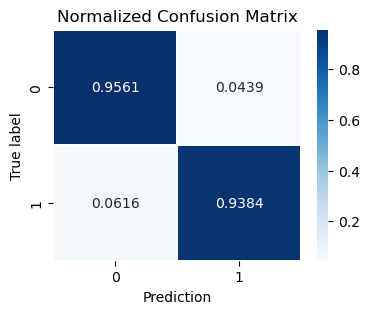


(Time taken: 3.40 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9397,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9427,0.9329,0.9475,0.9438,0.9497,0.9309,0.9446,0.9599,0.9608


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9452 ||



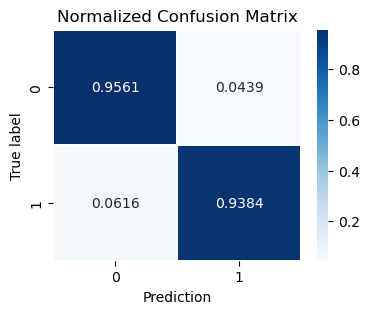


(Time taken: 3.20 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9471,0.9279,0.9456,0.9440,0.9434,0.9381,0.9460,0.9545,0.9546


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9496 ||



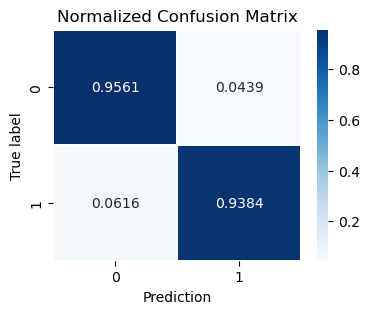


(Time taken: 2.11 secs)


In [22]:
run_experiment(knn, 'knn')

# Decision Tree

In [23]:
dtree = DecisionTreeClassifier(
    max_depth=6, 
    class_weight='balanced',
    random_state=SEED
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9545,0.9397,0.9495,0.9520,0.9569,0.9470,0.9507,0.9643,0.9704
ROC-AUC,0.9444,0.9388,0.9451,0.9562,0.9584,0.9413,0.9486,0.9621,0.9720


Refit to full training data and evaluate:

|| Accuracy: 0.9582 || ROC-AUC: 0.9641 ||



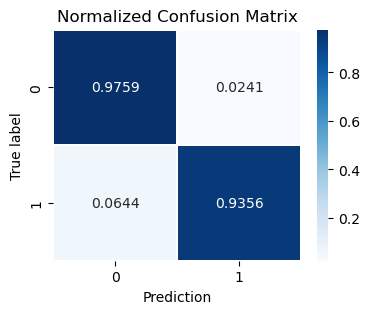


(Time taken: 1.45 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9545,0.941,0.9495,0.9520,0.9569,0.9483,0.9520,0.9643,0.9704
ROC-AUC,0.9444,0.941,0.9451,0.9562,0.9584,0.9420,0.9506,0.9621,0.9720


Refit to full training data and evaluate:

|| Accuracy: 0.9594 || ROC-AUC: 0.9660 ||



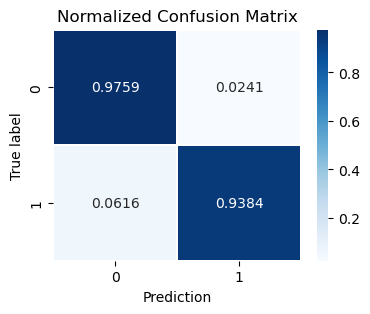


(Time taken: 1.21 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9454,0.9327,0.9496,0.9436,0.9456,0.9370,0.9440,0.9608,0.9583


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9503 ||



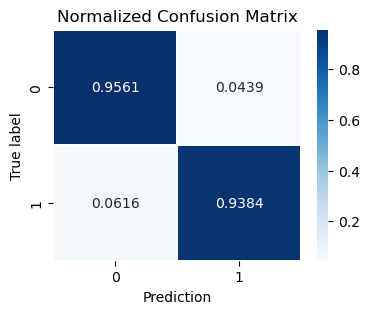


(Time taken: 0.84 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9507,0.9308,0.9470,0.9465,0.9430,0.9418,0.9546,0.9592,0.9624


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9527 ||



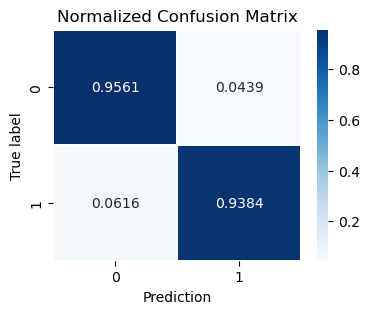


(Time taken: 0.72 secs)


In [24]:
run_experiment(dtree, 'dtree')

# Random Forest

In [25]:
rforest = RandomForestClassifier(
    n_estimators=150, 
    max_depth=6, 
    class_weight='balanced',
    random_state=SEED,
    n_jobs=1
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9569,0.9422,0.9557,0.9557,0.9544,0.9483,0.9594,0.9643,0.9704
ROC-AUC,0.9588,0.9364,0.9465,0.9444,0.9566,0.9470,0.9593,0.9643,0.9681


Refit to full training data and evaluate:

|| Accuracy: 0.9643 || ROC-AUC: 0.9612 ||



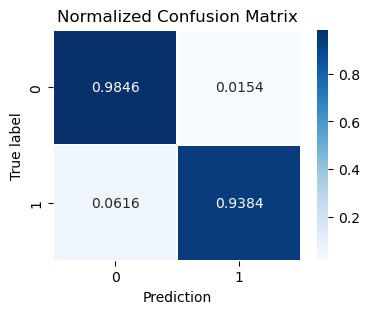


(Time taken: 22.70 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9582,0.9446,0.9581,0.9557,0.9557,0.9495,0.9594,0.9655,0.9717
ROC-AUC,0.9576,0.9398,0.9450,0.9484,0.9578,0.9470,0.9637,0.9633,0.9689


Refit to full training data and evaluate:

|| Accuracy: 0.9631 || ROC-AUC: 0.9610 ||



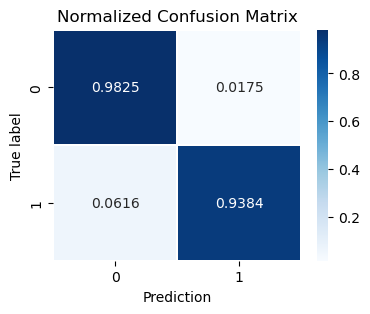


(Time taken: 20.72 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9475,0.9299,0.9381,0.9350,0.9515,0.9404,0.9376,0.9618,0.9613


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9513 ||



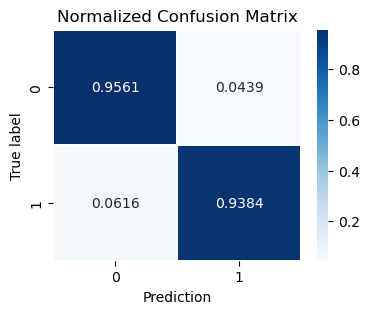


(Time taken: 10.55 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9511,0.9307,0.9476,0.9467,0.9446,0.9420,0.9543,0.9593,0.9627


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9531 ||



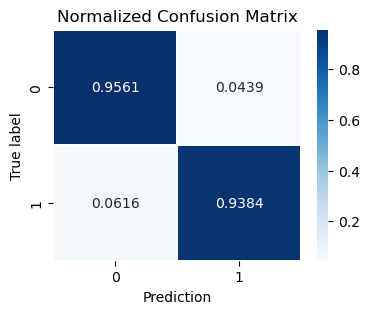


(Time taken: 8.96 secs)


In [26]:
run_experiment(rforest, 'rforest')

# AdaBoost

In [27]:
base_estimator = DecisionTreeClassifier(
    max_depth=6, 
    class_weight='balanced',
    random_state=SEED
)

adaboost = AdaBoostClassifier(
    estimator=base_estimator, 
    n_estimators=50, 
    learning_rate=0.05,
    algorithm='SAMME',
    random_state=SEED
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9582,0.9446,0.9569,0.9557,0.9557,0.947,0.9581,0.9655,0.9717
ROC-AUC,0.9610,0.9367,0.9525,0.9526,0.9571,0.945,0.9647,0.9623,0.9702


Refit to full training data and evaluate:

|| Accuracy: 0.9631 || ROC-AUC: 0.9659 ||



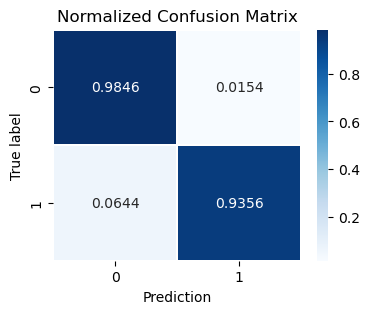


(Time taken: 31.31 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9582,0.9446,0.9569,0.9557,0.9557,0.947,0.9581,0.9655,0.9717
ROC-AUC,0.9615,0.9367,0.9513,0.9526,0.9566,0.948,0.9638,0.9622,0.9702


Refit to full training data and evaluate:

|| Accuracy: 0.9643 || ROC-AUC: 0.9660 ||



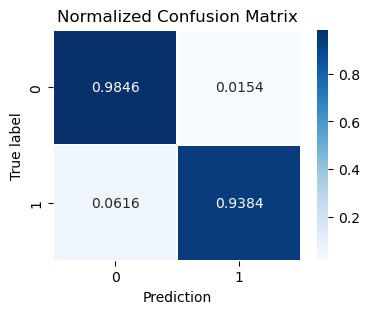


(Time taken: 32.05 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9503,0.9340,0.9537,0.9414,0.9453,0.9349,0.9428,0.9595,0.9608


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9431 ||



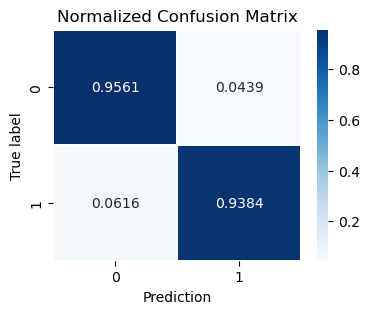


(Time taken: 9.00 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9425,0.9255,0.9438,0.9406,0.9401,0.9373,0.9433,0.9599,0.9592


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9456 ||



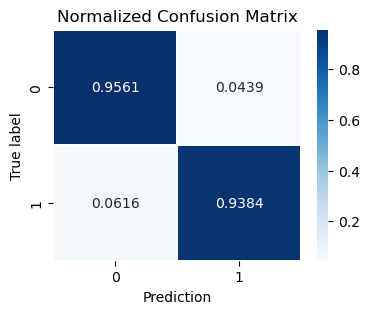


(Time taken: 7.43 secs)


In [28]:
run_experiment(adaboost, 'adaboost')

# Hist-Gradient Boosting

In [29]:
histgradient = HistGradientBoostingClassifier(
    learning_rate=0.02,
    max_iter=1000,
    max_depth=6,
    tol=2e-4,
    early_stopping=True,
    n_iter_no_change=25,
    validation_fraction=0.1,
    scoring=make_scorer(accuracy_score),
    class_weight='balanced',
    random_state=SEED
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9569,0.9422,0.9557,0.9532,0.9557,0.9483,0.9594,0.9643,0.9692
ROC-AUC,0.9578,0.9433,0.9520,0.9524,0.9580,0.9492,0.9595,0.9628,0.9684


Refit to full training data and evaluate:

|| Accuracy: 0.9631 || ROC-AUC: 0.9637 ||



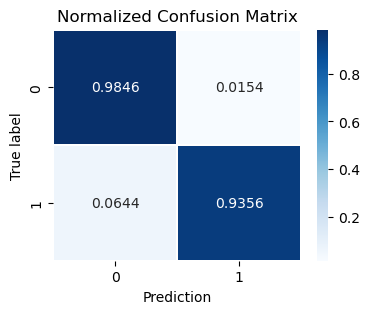


(Time taken: 6.02 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9582,0.9446,0.9581,0.9557,0.9557,0.9483,0.9594,0.9655,0.9704
ROC-AUC,0.9591,0.9440,0.9497,0.9548,0.9605,0.9441,0.9589,0.9622,0.9724


Refit to full training data and evaluate:

|| Accuracy: 0.9631 || ROC-AUC: 0.9639 ||



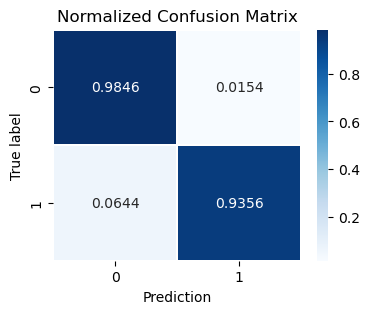


(Time taken: 5.61 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.941,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.947,0.9350,0.9502,0.9461,0.9457,0.9366,0.9442,0.9606,0.9601


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9496 ||



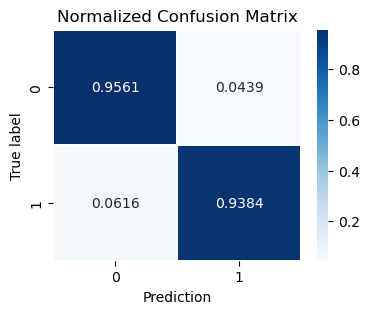


(Time taken: 5.63 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9531,0.9327,0.9502,0.9454,0.9425,0.9396,0.9561,0.9607,0.9620


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9534 ||



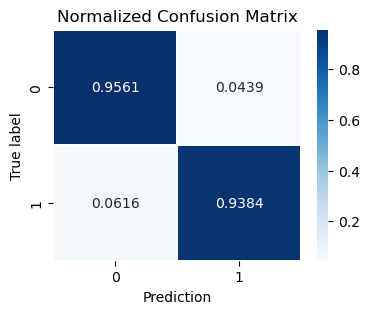


(Time taken: 5.09 secs)


In [30]:
run_experiment(histgradient, 'histgradient')

# Multi-Layer Perceptron

In [31]:
mlpnn = make_pipeline(
    StandardScaler(),
    MLPClassifier(
        activation='relu',
        solver='adam',
        alpha=1e-4,
        learning_rate_init=2e-4,
        max_iter=1000,
        tol=1e-4,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=25,
        random_state=SEED
    )
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.8180,0.8364,0.8300,0.8608,0.8128,0.8313,0.8424,0.8608,0.8658
ROC-AUC,0.9043,0.8991,0.9021,0.9214,0.8828,0.9051,0.9097,0.9266,0.9338


Refit to full training data and evaluate:

|| Accuracy: 0.8462 || ROC-AUC: 0.9129 ||



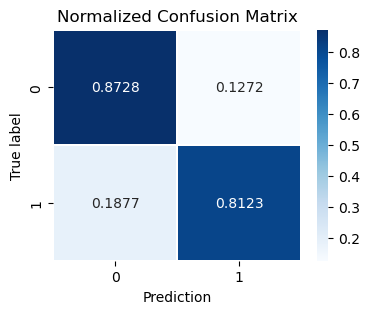


(Time taken: 87.09 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.941,0.9299,0.9433,0.9409,0.9397,0.9347,0.9372,0.9557,0.9532
ROC-AUC,0.953,0.9317,0.9451,0.9459,0.9489,0.9461,0.9491,0.9622,0.9663


Refit to full training data and evaluate:

|| Accuracy: 0.9496 || ROC-AUC: 0.9578 ||



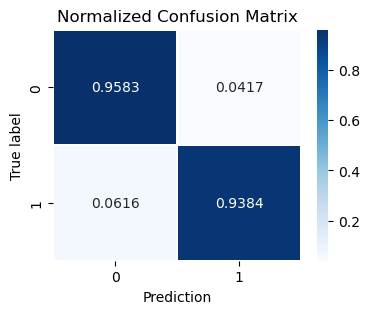


(Time taken: 31.26 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9360,0.9433,0.9372,0.9261,0.9569,0.9557
ROC-AUC,0.9493,0.9349,0.9400,0.9455,0.9539,0.9383,0.9473,0.9600,0.9632


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9550 ||



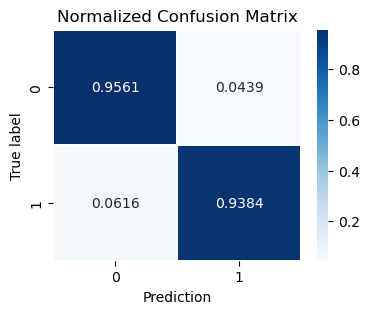


(Time taken: 24.86 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9473,0.9321,0.9445,0.9423,0.9493,0.9383,0.9472,0.9562,0.9633


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9544 ||



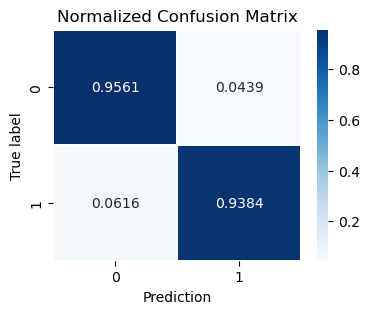


(Time taken: 29.15 secs)


In [32]:
run_experiment(mlpnn, 'mlpnn')

# XGBoost

In [33]:
class_ratio = train[TARGET].value_counts()[0] / train[TARGET].value_counts()[1]

xgb_params = {
    'booster': 'gbtree',
    'tree_method': 'hist',
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'scale_pos_weight': class_ratio,
    'learning_rate': 0.01,
    'n_estimators': 600,
    'device': 'cpu',
    'enable_categorical': True,
    'max_cat_to_onehot': 2,
    'verbosity': 0,
    'n_jobs': None,
    'seed': SEED
}

xgb = XGBClassifier(**xgb_params)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9569,0.9434,0.9557,0.9544,0.9544,0.9495,0.9581,0.9643,0.9680
ROC-AUC,0.9562,0.9404,0.9508,0.9555,0.9554,0.9505,0.9593,0.9573,0.9756


Refit to full training data and evaluate:

|| Accuracy: 0.9643 || ROC-AUC: 0.9676 ||



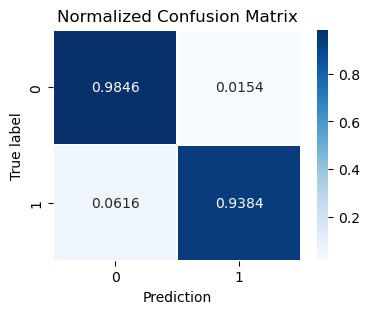


(Time taken: 23.62 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9582,0.9446,0.9557,0.9557,0.9557,0.9495,0.9569,0.9655,0.9717
ROC-AUC,0.9540,0.9409,0.9505,0.9559,0.9558,0.9505,0.9608,0.9583,0.9764


Refit to full training data and evaluate:

|| Accuracy: 0.9631 || ROC-AUC: 0.9658 ||



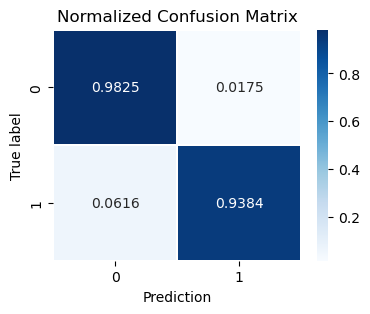


(Time taken: 24.59 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9499,0.9406,0.9477,0.9441,0.9441,0.9350,0.9441,0.9621,0.9625


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9481 ||



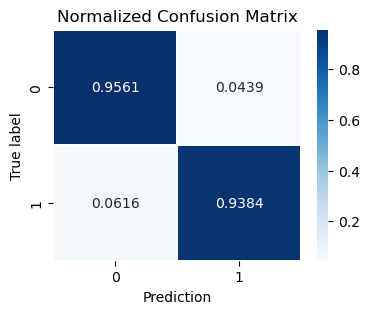


(Time taken: 16.48 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9507,0.9309,0.9472,0.9465,0.9424,0.9418,0.9543,0.9586,0.9623


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9528 ||



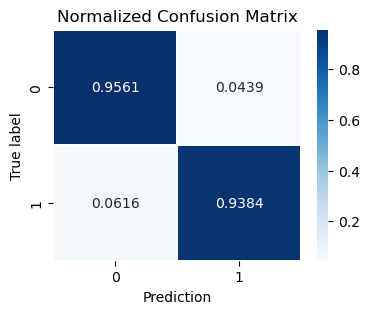


(Time taken: 12.75 secs)


In [34]:
run_experiment(xgb, 'xgb')

# CatBoost

In [35]:
catb_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'metric_period': 1,
    'iterations': 600,
    'learning_rate': 0.01,
    'auto_class_weights': 'Balanced',
    'task_type': 'CPU',
    'thread_count': -1,
    'verbose': False,
    'random_state': SEED
}

catb = CatBoostClassifier(**catb_params)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9569,0.9434,0.9557,0.9544,0.9544,0.9483,0.9594,0.9618,0.9692
ROC-AUC,0.9569,0.9435,0.9512,0.9523,0.9541,0.9503,0.9644,0.9613,0.9729


Refit to full training data and evaluate:

|| Accuracy: 0.9606 || ROC-AUC: 0.9638 ||



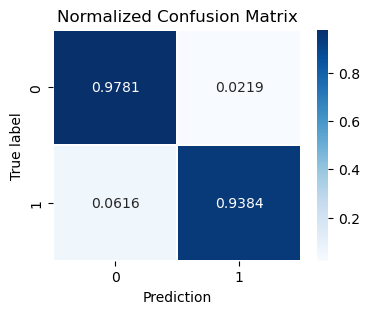


(Time taken: 55.53 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9582,0.9446,0.9581,0.9557,0.9544,0.9495,0.9594,0.9655,0.9729
ROC-AUC,0.9580,0.9422,0.9513,0.9510,0.9552,0.9497,0.9634,0.9602,0.9739


Refit to full training data and evaluate:

|| Accuracy: 0.9643 || ROC-AUC: 0.9633 ||



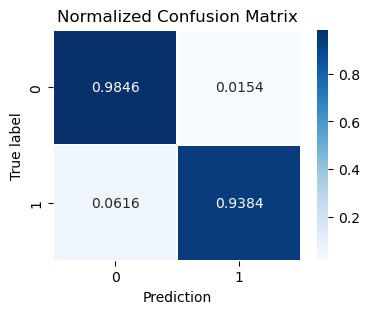


(Time taken: 60.21 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9502,0.9387,0.9485,0.9434,0.9437,0.9361,0.9451,0.9592,0.9609


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9501 ||



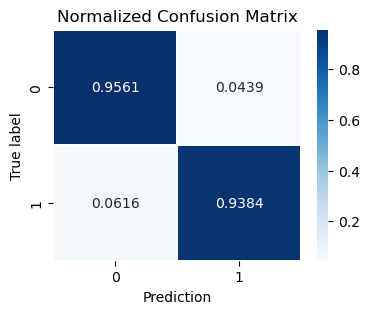


(Time taken: 43.15 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9508,0.9309,0.9469,0.9434,0.9456,0.9412,0.9539,0.9590,0.9617


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9530 ||



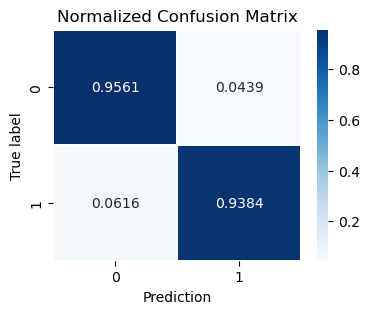


(Time taken: 35.56 secs)


In [36]:
run_experiment(catb, 'catb')

# Model Ensembling

In [37]:
base_models = [
    ('logreg', logreg),
    ('gaussnb', gaussnb),
    ('knn', knn),
    ('mlpnn', mlpnn),
    ('dtree', dtree),
    ('rforest', rforest),
    ('adaboost', adaboost),
    ('histgradient', histgradient),
    ('xgboost', xgb),
    ('catboost', catb)
]

## Voting Classifier - Soft

In [38]:
softvoting = VotingClassifier(estimators=base_models, voting='soft')


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9582,0.9422,0.9569,0.9557,0.9557,0.9495,0.9569,0.9643,0.9704
ROC-AUC,0.9574,0.9369,0.9465,0.9511,0.9533,0.9477,0.9594,0.9617,0.9707


Refit to full training data and evaluate:

|| Accuracy: 0.9606 || ROC-AUC: 0.9635 ||



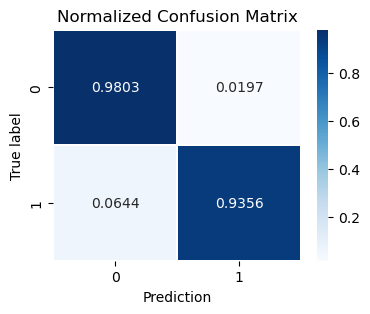


(Time taken: 249.68 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9569,0.9446,0.9581,0.9557,0.9544,0.9495,0.9594,0.9643,0.9729
ROC-AUC,0.9577,0.9393,0.9451,0.9507,0.9523,0.9467,0.9601,0.9617,0.9705


Refit to full training data and evaluate:

|| Accuracy: 0.9643 || ROC-AUC: 0.9644 ||



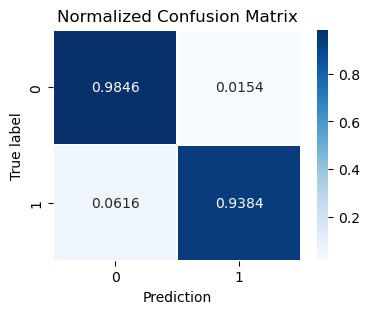


(Time taken: 169.65 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9492,0.9343,0.9436,0.9402,0.9472,0.9384,0.9432,0.9594,0.9654


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9553 ||



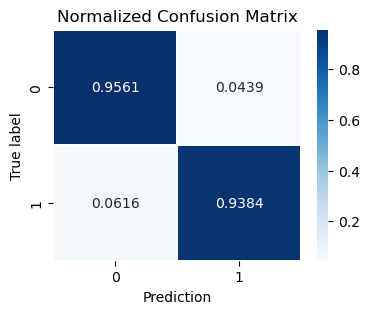


(Time taken: 110.25 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9493,0.9291,0.9425,0.9405,0.9421,0.9428,0.9452,0.9531,0.9642


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9583 ||



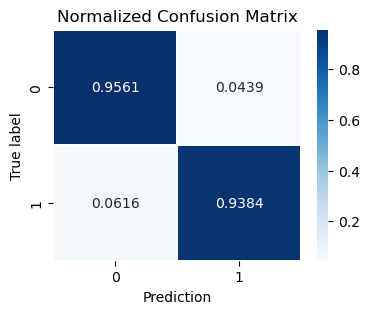


(Time taken: 95.42 secs)


In [39]:
run_experiment(softvoting, 'softvoting')

## Stacking classifier - No passthrough

In [40]:
final_estimator = make_pipeline(
    StandardScaler(), 
    LogisticRegression(
        solver='saga', 
        max_iter=1000, 
        penalty='elasticnet', 
        l1_ratio=0.5, 
        random_state=SEED
    )
)

In [41]:
stackingnopass = StackingClassifier(
    estimators=base_models,
    final_estimator=final_estimator,
    cv=StratifiedKFold(n_splits=7, shuffle=True, random_state=SEED),
    stack_method='predict_proba',
    passthrough=False,
    n_jobs=-1
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9582,0.9422,0.9569,0.9544,0.9557,0.9483,0.9581,0.9643,0.9717
ROC-AUC,0.9558,0.9476,0.9521,0.9514,0.9599,0.9441,0.9625,0.9622,0.9732


Refit to full training data and evaluate:

|| Accuracy: 0.9631 || ROC-AUC: 0.9648 ||



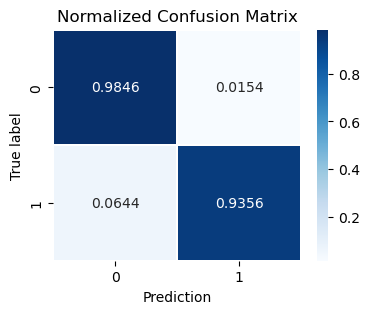


(Time taken: 1036.45 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9594,0.9446,0.9581,0.9557,0.9557,0.9495,0.9594,0.9655,0.9729
ROC-AUC,0.9579,0.9477,0.9511,0.9546,0.9598,0.9484,0.9611,0.9581,0.9753


Refit to full training data and evaluate:

|| Accuracy: 0.9643 || ROC-AUC: 0.9643 ||



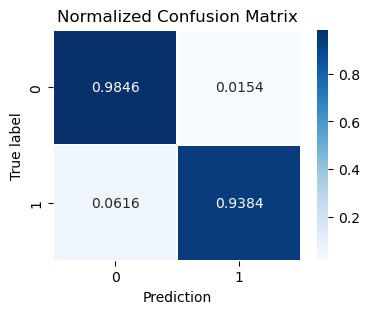


(Time taken: 702.77 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.941,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.949,0.9362,0.9463,0.9463,0.9456,0.9319,0.9488,0.9591,0.9637


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9531 ||



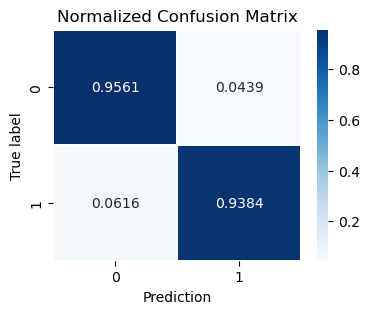


(Time taken: 435.51 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9521,0.9285,0.9437,0.9412,0.9389,0.9396,0.9478,0.9537,0.9611


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9573 ||



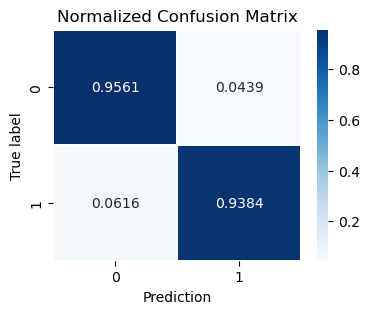


(Time taken: 356.70 secs)


In [42]:
run_experiment(stackingnopass, 'stackingnopass')

## Stacking classifier - Passthrough

In [43]:
stackingpass = StackingClassifier(
    estimators=base_models,
    final_estimator=final_estimator,
    cv=StratifiedKFold(n_splits=7, shuffle=True, random_state=SEED),
    stack_method='predict_proba',
    passthrough=True,
    n_jobs=-1
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9582,0.9422,0.9557,0.9544,0.9557,0.9483,0.9581,0.9643,0.9717
ROC-AUC,0.9586,0.9498,0.9525,0.9561,0.9597,0.9433,0.9613,0.9626,0.9729


Refit to full training data and evaluate:

|| Accuracy: 0.9631 || ROC-AUC: 0.9627 ||



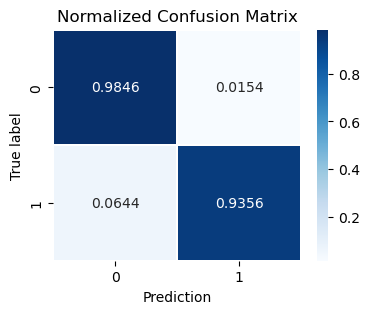


(Time taken: 1001.04 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9594,0.9446,0.9581,0.9557,0.9557,0.9495,0.9594,0.9655,0.9729
ROC-AUC,0.9581,0.9509,0.9543,0.9557,0.9577,0.9423,0.9589,0.9582,0.9764


Refit to full training data and evaluate:

|| Accuracy: 0.9643 || ROC-AUC: 0.9632 ||



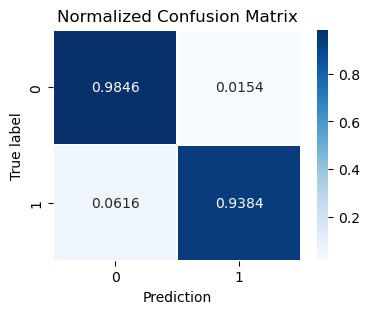


(Time taken: 745.93 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9494,0.9324,0.9446,0.9495,0.9418,0.9298,0.9455,0.9586,0.9652


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9526 ||



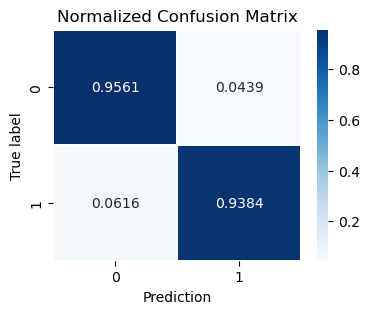


(Time taken: 467.03 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9471,0.9256,0.9434,0.9453,0.9382,0.9354,0.9491,0.9547,0.9630


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9571 ||



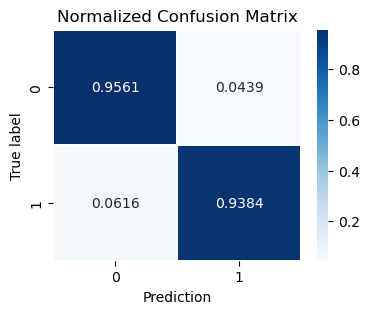


(Time taken: 397.46 secs)


In [44]:
run_experiment(stackingpass, 'stackingpass')